# 8 - Análise Comparativa entre modelos de séries temporais

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook é uma comparação entre modelos de séries temporais:

* **Modelo Total**: Modelo autorregressivo integrável de médias móveis com sazonalidade (`SARIMA`), treinado no faturamento total;
* **Modelo *Megazord***: Modelos treinados individualmente para cada produto, e somados para obter a previsão de faturamento total.

In [1]:
# importação de bibliotecas
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import pickle

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae, r2_score

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics, py_scripts.models
os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

Vamos importar os dados:

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

## Importação dos modelos

Vamos agora importar os modelos para comparação. 


### Modelo com produtos individuais (modelo *Megazord*)

Primeiramente, importaremos o modelo *Megazord*:

In [3]:
modelo_megazord = py_scripts.models.modelo_produtos()
modelo, serie_treino = modelo_megazord.get_models()

print(modelo_megazord)

Modelos:
             alimenticio:  ARIMA(1,2,0)(0,2,0)[12]          
    auxilio_final_de_ano:  ARIMA(3,0,2)(1,6,0)[12]          
             bonificacao:  ARIMA(1,0,2)(0,1,1)[12] intercept
                   saude:  ARIMA(0,1,0)(0,0,0)[12] intercept
              transporte:  ARIMA(0,1,0)(0,0,0)[12] intercept


### Modelo do faturamento total (modelo Total)

Vamos agora importar o modelo treinado nos faturamentos totais:

In [4]:
with open(fr'../models/total.model', 'rb') as modelo_arq:
    unpickler = pickle.Unpickler(modelo_arq)
    modelo_dict = unpickler.load()
    modelo['total'] = modelo_dict['modelo']
    serie_treino['total'] = modelo_dict['serie_treino']

In [5]:
print(f"Modelo total: {modelo['total']}")

Modelo total:  ARIMA(0,2,0)(1,1,1)[12] intercept


## Comparação

Estamos preparados para comparar os modelos

In [6]:
fat_total = tswide.sum(axis = 'columns')
series_begin = '2019-06'

### Análise gráfica

Plotamos o ajuste do modelo *Megazord*:

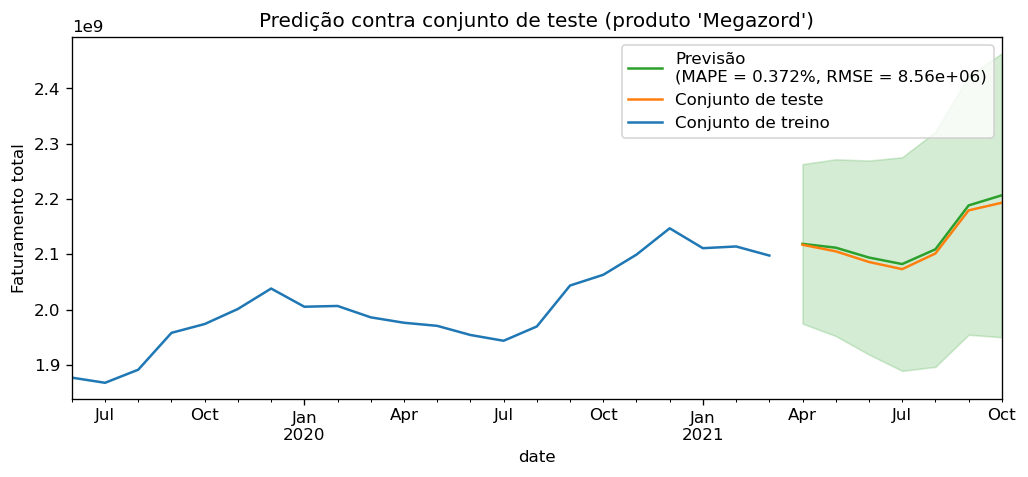

In [7]:
test_begin = modelo_megazord.get_all_test_begin()
fat_megazord_train = fat_total[series_begin: test_begin].iloc[:-1]
fat_megazord_test = fat_total[test_begin:]

preds_megazord = py_scripts.plots.ajuste_grafico(
    modelo = modelo_megazord, 
    produto = 'Megazord',
    serie_treino = fat_megazord_train,
    serie_teste = fat_megazord_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

Plotamos agora o ajuste do modelo Total:

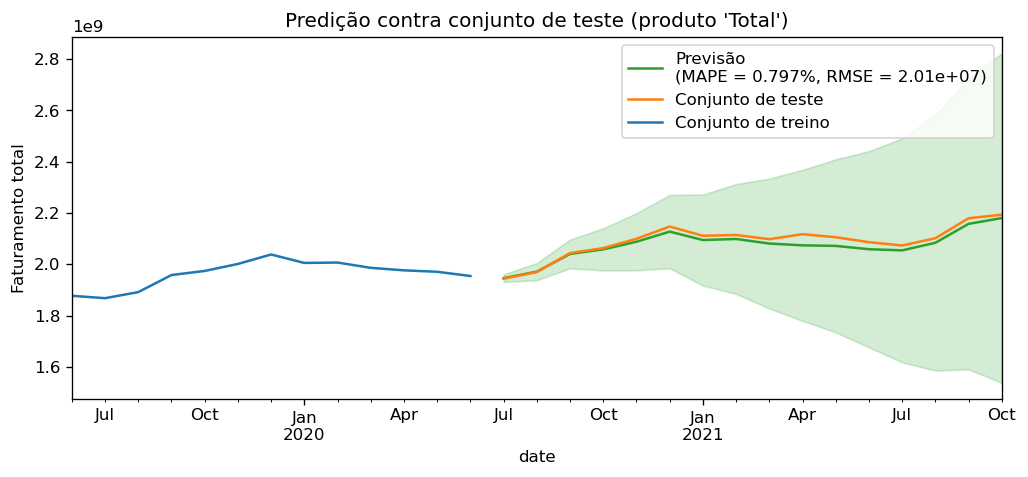

In [8]:
modelo_total = modelo['total']
fat_total_train = serie_treino['total'][series_begin:]
fat_total_test = fat_total[fat_total_train.index[-1]:].iloc[1:]

preds_total = py_scripts.plots.ajuste_grafico(
    modelo = modelo_total, 
    produto = 'Total',
    serie_treino = fat_total_train,
    serie_teste = fat_total_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

Comparando os gráficos:

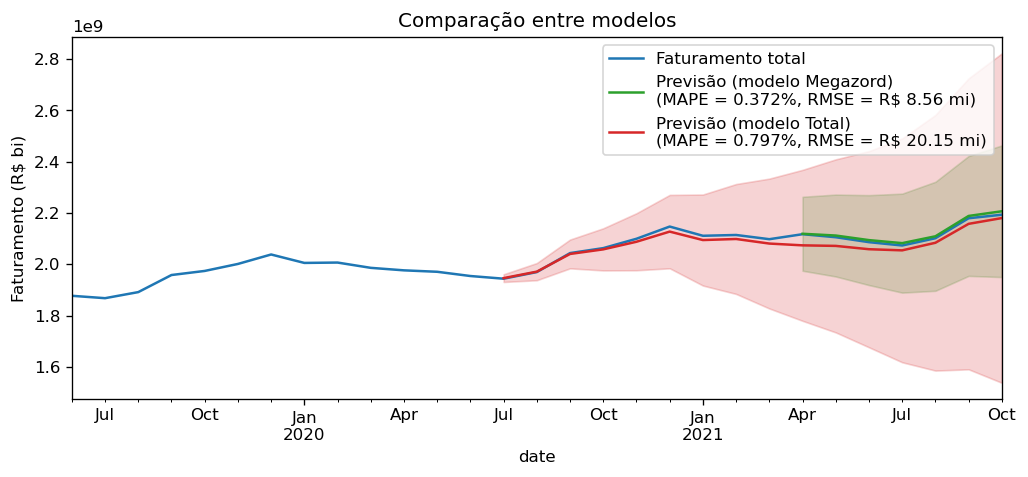

In [9]:
fig = plt.figure()

palette = sns.color_palette(None, 5)

fat_total[series_begin:].plot(label = 'Faturamento total', color = palette[0])

# plotando a previsão do modelo megazord
idx_megazord = pd.date_range(
    start = modelo_megazord.get_all_test_begin(),
    end = fat_total.index[-1],
    freq = 'MS'
)

n_periodos_megazord = idx_megazord.shape[0]

# vamos calcular a previsão do modelo Megazord, incluindo o intervalo de confianca, retornando um dataframe
preds_megazord_ci = modelo_megazord.predict(
    n_periods = n_periodos_megazord,
    return_conf_int = True,
    predict_array = False,
)

# calculando métricas
metricas_preds_megazord = py_scripts.metrics.calc_metricas(
    y_true = fat_megazord_test,
    y_pred = preds_megazord
)
label_megazord = (
    'Previsão (modelo Megazord)'
    f"\n(MAPE = {metricas_preds_megazord['MAPE']:.3%}, "
    f"RMSE = R$ {metricas_preds_megazord['RMSE']/10**6:.2f} mi)"
)

# plotando
preds_megazord_ci['predicted_mean'].plot(label = label_megazord, color = palette[2])
plt.fill_between(idx_megazord, preds_megazord_ci['lb'], preds_megazord_ci['ub'], alpha = 0.2, color = palette[2])

# plotando a previsão do modelo Total
idx_total = pd.date_range(
    start = fat_total_test.index[0],
    end = fat_total.index[-1],
    freq = 'MS'
)

n_periodos_total = idx_total.shape[0]

# vamos calcular a previsão do modelo Megazord, incluindo o intervalo de confianca, retornando um array
preds_total_ci_arr = modelo_total.predict(
    n_periods = n_periodos_total,
    return_conf_int = True
)

# transformando o array em uma Series e um DataFrame
preds_total_ci_mean = pd.Series(preds_total_ci_arr[0], index = idx_total)

preds_total_ci_lbub = pd.DataFrame(preds_total_ci_arr[1], columns = ['lb', 'ub'], index = idx_total)

# calculando métricas
metricas_preds_total = py_scripts.metrics.calc_metricas(
    y_true = fat_total_test,
    y_pred = preds_total
)
label_total = (
    'Previsão (modelo Total)'
    f"\n(MAPE = {metricas_preds_total['MAPE']:.3%}, "
    f"RMSE = R$ {metricas_preds_total['RMSE']/10**6:.2f} mi)"
)

# plotando
preds_total_ci_mean.plot(label = label_total, color = palette[3])
plt.fill_between(idx_total, preds_total_ci_lbub['lb'], preds_total_ci_lbub['ub'], alpha = 0.2, color = palette[3])

plt.title('Comparação entre modelos')
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()


O modelo *Megazord* parece melhor ajustado que o modelo Total, embora o conjunto de teste daquele seja menor do que o deste.

Além de ser melhor ajustado, mesmo com conjunto de teste menor o modelo *Megazord* tem um intervalo de confiança menor.

### Métricas

Vamos agora calcular algumas métricas quantitativas.

Começamos pelo modelo *Megazord*:

In [10]:
metricas = {}

In [11]:
kwargs_ajuste = dict(
    y_true = fat_megazord_test,
    y_pred = preds_megazord,
)

metricas['megazord'] = py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
       MAPE: 0.372%
       RMSE: 8.561e+06
        MAE: 7.915e+06


Partimos para o cálculo das métricas do modelo Total:

In [12]:
kwargs_ajuste = dict(
    y_true = fat_total_test,
    y_pred = preds_total,
)

metricas['total'] = py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
       MAPE: 0.797%
       RMSE: 2.015e+07
        MAE: 1.683e+07


O modelo *Megazord* apresenta métricas melhores que o modelo Total:

| Métrica | modelo *Megazord* | modelo Total | Dif.        | % Dif. |
|---------|-------------------|--------------|-------------|--------|
| MAPE    | **0.372%**        | 0.797%       | 0.425 p.p.  | 53.3%  |
| RMSE    | **R$ 8.56 mi**    | R$ 20.2 mi   | R$ 11.59 mi | 57.4%  |
| MAE     | **R$ 7.91 mi**    | R$ 16.8 mi   | R$ 8.92 mi  | 53.1%  |

Além disso, conforme dissemos anteriormente, o modelo *Megazord* apresenta intervalos de confiança mais abertos:

In [13]:
amplitude_ci = pd.DataFrame(
    [], index = fat_total_test.index
)

amplitude_ci['megazord'] = preds_megazord_ci['ub'] - preds_megazord_ci['lb']
amplitude_ci['total'] = preds_total_ci_lbub['ub'] - preds_total_ci_lbub['lb']

# dropando qualquer linha em que um dos valores é NaN, já que não é possível uma comparação
amplitude_ci.dropna(inplace = True)

# calculando o melhor em cada mês
amplitude_ci['melhor'] = np.where(amplitude_ci['megazord'] <= amplitude_ci['total'], 'megazord', 'total')

print('Amplitude dos intervalos de confiança (menor é melhor):')
amplitude_ci

Amplitude dos intervalos de confiança (menor é melhor):


,megazord,total,melhor
date,,,
2021-04-01,2.885137e+08,5.889511e+08,megazord
2021-05-01,3.195240e+08,6.751869e+08,megazord
2021-06-01,3.508514e+08,7.652533e+08,megazord
2021-07-01,3.861840e+08,8.733392e+08,megazord
2021-08-01,4.252548e+08,9.972770e+08,megazord
2021-09-01,4.677831e+08,1.135117e+09,megazord
2021-10-01,5.134695e+08,1.285250e+09,megazord


## Previsão até o fim de 2021

Vamos prever os faturamentos até o fim de 2021:

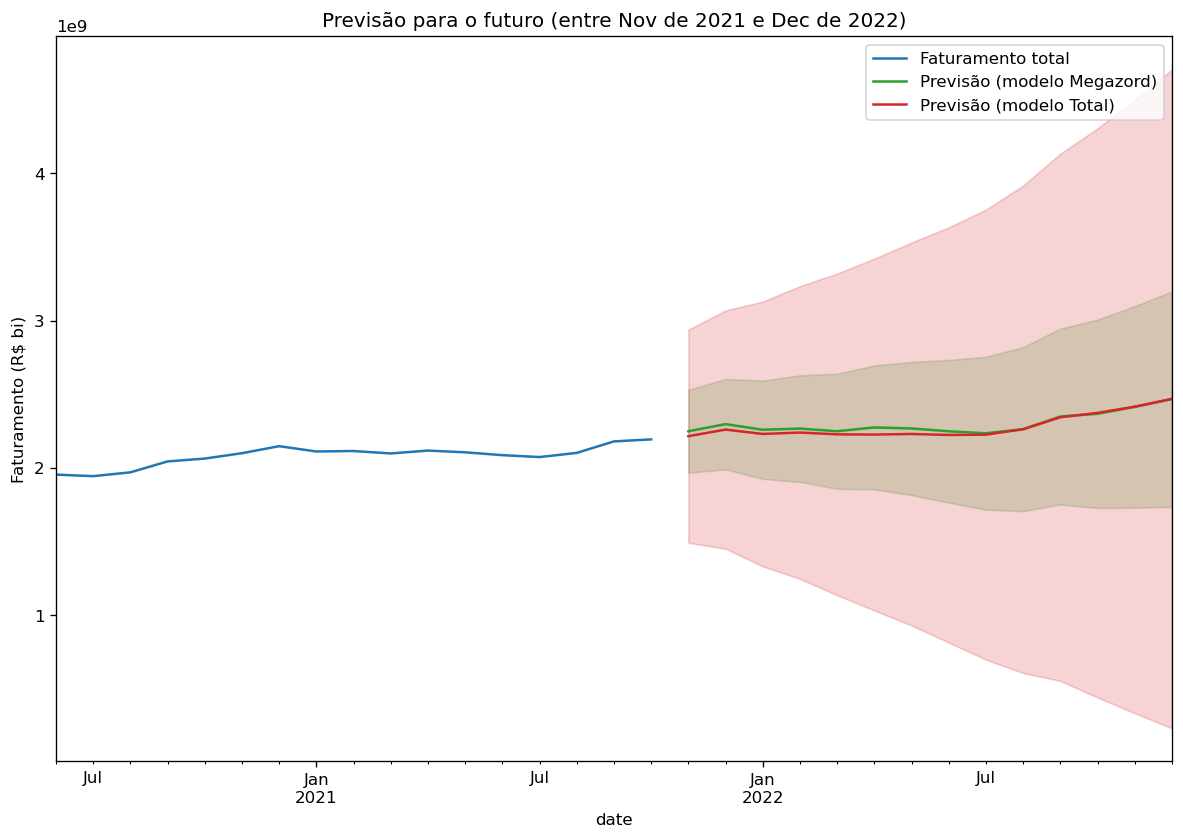

In [14]:
fat_total_begin = '2020-06'
previsao_desde = fat_total.index[-1] + pd.offsets.MonthBegin()
previsao_ate = '2022-12'

idx_previsao = pd.date_range(
    start = previsao_desde,
    end = previsao_ate,
    freq = 'MS'
)

fig = plt.figure(figsize = (12, 8))

palette = sns.color_palette(None, 5)

fat_total[fat_total_begin:].plot(label = 'Faturamento total', color = palette[0])

# plotando a previsão do modelo megazord
idx_megazord = pd.date_range(
    start = modelo_megazord.get_all_test_begin(),
    end = previsao_ate,
    freq = 'MS'
)

n_periodos_megazord = idx_megazord.shape[0]

# vamos calcular a previsão do modelo Megazord, incluindo o intervalo de confianca, retornando um dataframe
preds_megazord_ci = modelo_megazord.predict(
    n_periods = n_periodos_megazord,
    return_conf_int = True,
    predict_array = False,
)

preds_megazord_ci_previsao = preds_megazord_ci[previsao_desde:]

# plotando
preds_megazord_ci_previsao['predicted_mean'].plot(label = 'Previsão (modelo Megazord)', color = palette[2])
plt.fill_between(idx_previsao, preds_megazord_ci_previsao['lb'], preds_megazord_ci_previsao['ub'], alpha = 0.2, color = palette[2])

# plotando a previsão do modelo Total
idx_total = pd.date_range(
    start = fat_total_test.index[0],
    end = previsao_ate,
    freq = 'MS'
)

n_periodos_total = idx_total.shape[0]

# vamos calcular a previsão do modelo Megazord, incluindo o intervalo de confianca, retornando um array
preds_total_ci_arr = modelo_total.predict(
    n_periods = n_periodos_total,
    return_conf_int = True
)

# transformando o array em uma Series e um DataFrame
preds_total_ci_mean = pd.Series(preds_total_ci_arr[0], index = idx_total)

preds_total_ci_lbub = pd.DataFrame(preds_total_ci_arr[1], columns = ['lb', 'ub'], index = idx_total)

# a previsão deve partir do fim da série

preds_total_ci_mean = preds_total_ci_mean[previsao_desde:]
preds_total_ci_lbub = preds_total_ci_lbub.loc[previsao_desde:]

# plotando
preds_total_ci_mean.plot(label = 'Previsão (modelo Total)', color = palette[3])
plt.fill_between(idx_previsao, preds_total_ci_lbub['lb'], preds_total_ci_lbub['ub'], alpha = 0.2, color = palette[3])

# data da previsao
dtfmt = '%b de %Y'

previsao_de_dt = idx_previsao[0]
previsao_de_str = previsao_de_dt.strftime(format = dtfmt)

previsao_ate_dt = idx_previsao[-1]
previsao_ate_str = previsao_ate_dt.strftime(format = dtfmt)

plt.title(f'Previsão para o futuro (entre {previsao_de_str} e {previsao_ate_str})')
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

## Conclusão

Dada a análise anterior, **escolheria para uso em produção em minha empresa o modelo que considera a soma dos modelos de cada produto (batizado de modelo *Megazord*)**, dado que

* apresenta métricas (MAPE, RMSE e MAE) melhores. As métricas refletem diretamente o impacto para o negócio: qual é o erro médio ao se fazer uma previsão de faturamento em uma data qualquer; e
* apresenta intervalo de confiança mais estreito. Esse critério também se relaciona com a probabilidade de se fazer uma previsão errada.